# This Notebook have to be executed from the AWS Sagemaker Studio environment

In [2]:
import os
from dotenv import load_dotenv
import boto3

key_id = os.environ.get('AWS_ACCESS_KEY_ID', None)
secret_key = os.environ.get('AWS_SECRET_ACCESS_KEY', None)
s3 = boto3.resource('s3',
        aws_access_key_id=key_id,
        aws_secret_access_key=secret_key)

print('You are logged in!')

You are logged in!


In [4]:
import awswrangler as wr
import boto3
import pandas as pd
import numpy as np
import re
from sagemaker import get_execution_role

import matplotlib.pyplot as plt
from tqdm import tqdm

# role = get_execution_role()
s3 = boto3.resource('s3')

In [5]:
s3 = boto3.resource('s3')
my_bucket = s3.Bucket('icusics-db')

In [6]:
tables = []
for my_bucket_object in my_bucket.objects.all():
    tables.append(my_bucket_object.key)
tables = pd.Series(tables)

In [7]:
variables = wr.s3.read_parquet('s3://icusics-db/d_variables/d_variables.parquet')
patients = wr.s3.read_parquet('s3://icusics-db/patients/patients.parquet')
diagnoses = wr.s3.read_parquet('s3://icusics-db/diagnoses/diagnoses_h4.parquet')

In [9]:
creat_idx = [
    1020000600,2020000600,3020000600,
    4020000600,5020000600,6020000600
]

creatinine = []
for i in tqdm(range(1,7)):
    labresults_numeric = wr.s3.read_parquet(f's3://icusics-db/labresults_numeric/labresults_numeric_h{i}.parquet')
    ith = labresults_numeric[labresults_numeric.a_variableid.isin(creat_idx)]
    creatinine.append(ith)
    
creatinine = pd.concat(creatinine)
creatinine

100%|██████████| 6/6 [00:09<00:00,  1.53s/it]


,a_patientid,a_variableid,time,value
189,1001170,1020000600,2324,1.33
190,1001170,1020000600,3736,1.20
191,1001170,1020000600,8076,0.95
192,1001170,1020000600,9485,0.85
193,1001170,1020000600,10952,0.92
...,...,...,...,...
744038,6986768,6020000600,1393,1.08
744157,6995665,6020000600,-251,0.61
744158,6995665,6020000600,217,0.61
744159,6995665,6020000600,1032,0.61


In [10]:
cols = {'a_patientid':'a_patientid', 'time':'time_48', 'value':'value_48'}
cr48 = creatinine.loc[:, cols.keys()].rename(columns=cols)

m_48 = creatinine.merge(cr48, how='left', on=['a_patientid'])
m_48 = m_48.query("time_48 < time and time_48 > time - 2880")
m_48 = m_48.merge(creatinine, how='right', on=creatinine.columns.tolist())
m_48 = m_48.groupby(['a_patientid','a_variableid','time','value']).value_48.min().reset_index()

cols = {'a_patientid':'a_patientid', 'time':'time_7', 'value':'value_7'}
cr7 = creatinine.loc[:, cols.keys()].rename(columns=cols)

m_7 = creatinine.merge(cr7, how='left', on=['a_patientid'])
m_7 = m_7.query("time_7 < time and time_7 > time - 10080")
m_7 = m_7.merge(creatinine, how='right', on=creatinine.columns.tolist())
m_7 = m_7.groupby(['a_patientid','a_variableid','time','value']).value_7.min().reset_index()

kdigo_creatinine = m_48.merge(m_7, how='inner', on=['a_patientid', 'a_variableid', 'time', 'value'])

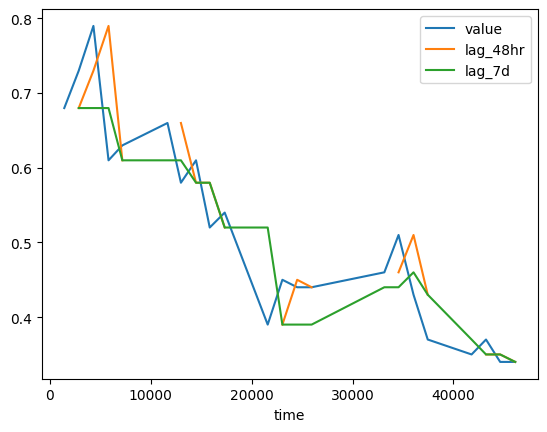

In [11]:
ax = kdigo_creatinine.query("a_patientid==4000318").plot(x='time', y='value', label='value')
_ = kdigo_creatinine.query("a_patientid==4000318").plot(x='time', y='value_48',ax=ax, label='lag_48hr')
_ = kdigo_creatinine.query("a_patientid==4000318").plot(x='time', y='value_7',ax=ax, label='lag_7d')

_ = ax.legend()

plt.show()

## Urine Output

In [13]:
uro_idx = [
    1010010000,2010010000,3010010000,
    4010010000,5010010000,6010010000
]

urineOutput = []
for i in tqdm(range(1,7)):
    labresults_numeric = wr.s3.read_parquet(f's3://icusics-db/observed_numeric/observed_numeric_h{i}.parquet')
    ith = labresults_numeric[labresults_numeric.a_variableid.isin(uro_idx)]
    urineOutput.append(ith)
    
urineOutput = pd.concat(urineOutput)
urineOutput

100%|██████████| 6/6 [00:16<00:00,  2.76s/it]


,a_patientid,a_variableid,time,value
8,1000091,1010010000,11,180.0
9,1000091,1010010000,34,90.0
10,1000091,1010010000,94,90.0
11,1000091,1010010000,154,200.0
12,1000091,1010010000,274,220.0
...,...,...,...,...
9920959,6995665,6010010000,2513,130.0
9920960,6995665,6010010000,2633,250.0
9920961,6995665,6010010000,2753,150.0
9920962,6995665,6010010000,2873,100.0


In [14]:
def get_lag(df, l, merge_idx=['a_patientid'], agg_fnc=np.sum, agg_col='value'):
    orig_cols = df.columns.tolist()
    custom_cols = list(map(lambda x: x + '_' + str(l) if x not in merge_idx else x, orig_cols))

    cols = {'time': f'time_{l}', 'value': f'value_{l}'}
    df_l = df.rename(columns=cols)

    m_l = df.merge(df_l, how='left', on=merge_idx)
    lhr = l * 60
    q_str = f"{cols['time']} < time and {cols['time']} > time - {lhr}"
    m_l = m_l.query(q_str)
    m_l = m_l.merge(df, how='right', on=df.columns.tolist())
    m_l = m_l.groupby(df.columns.tolist())[cols[agg_col]].apply(agg_fnc).reset_index()
    return m_l

In [15]:
u_patients = urineOutput.a_patientid.unique()

l6 = []
t6 = []
l12 = []
t12 = []
l24 = []
t24 = []

delta = 100
for i in tqdm(range(0, u_patients.shape[0], delta)):
    p_round = u_patients[i:i+delta]
    df = urineOutput[urineOutput.a_patientid.isin(p_round)].loc[:, ['a_patientid', 'time', 'value']]
    i6 = get_lag(df, l=6)
    i12 = get_lag(df, l=12)
    i24 = get_lag(df, l=24)
    j6 = get_lag(df, l=6, agg_col='time', agg_fnc=np.min)
    j12 = get_lag(df, l=12, agg_col='time', agg_fnc=np.min)
    j24 = get_lag(df, l=24, agg_col='time', agg_fnc=np.min)
    l6.append(i6)
    l12.append(i12)
    l24.append(i24)
    t6.append(j6)
    t12.append(j12)
    t24.append(j24)

100%|██████████| 209/209 [21:03<00:00,  6.05s/it]


In [16]:
uo_l6 = pd.concat(l6, ignore_index=True)
uo_l12 = pd.concat(l12, ignore_index=True)
uo_l24 = pd.concat(l24, ignore_index=True)

uo_t6 = pd.concat(t6, ignore_index=True)
uo_t12 = pd.concat(t12, ignore_index=True)
uo_t24 = pd.concat(t24, ignore_index=True)

uo_t6['uo_tm_6hr'] = (uo_t6.time - uo_t6.time_6) / 60
uo_t12['uo_tm_12hr'] = (uo_t12.time - uo_t12.time_12) / 60
uo_t24['uo_tm_24hr'] = (uo_t24.time - uo_t24.time_24) / 60

uo_t6 = uo_t6.drop(columns='time_6')
uo_t12 = uo_t12.drop(columns='time_12')
uo_t24 = uo_t24.drop(columns='time_24')

In [17]:
uo_m1 = uo_l6.merge(uo_l12, on=['a_patientid','time','value'])
uo_m2 = uo_m1.merge(uo_l24, on=['a_patientid','time','value'])
uo_m3 = uo_m2.merge(uo_t6, on=['a_patientid','time','value'])
uo_m4 = uo_m3.merge(uo_t12, on=['a_patientid','time','value'])
uo_m5 = uo_m4.merge(uo_t24, on=['a_patientid','time','value'])

In [24]:
patients_merge = patients.loc[:, ['a_patientid','weight']]
kdigo_uo = uo_m5.merge(patients_merge, how='inner', on='a_patientid')
kdigo_uo['uo_rt_6hr'] = kdigo_uo.value_6 / kdigo_uo.weight / kdigo_uo.uo_tm_6hr
kdigo_uo['uo_rt_12hr'] = kdigo_uo.value_12 / kdigo_uo.weight / kdigo_uo.uo_tm_12hr
kdigo_uo['uo_rt_24hr'] = kdigo_uo.value_24 / kdigo_uo.weight / kdigo_uo.uo_tm_24hr

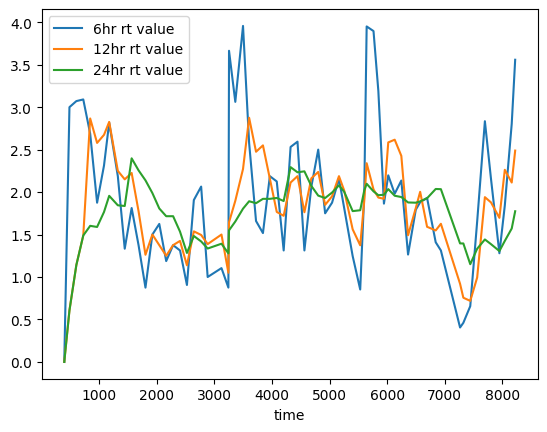

In [25]:
# ax = uo_m6.query('a_patientid==4000592').plot(x='time', y='value', label='value')
ax = kdigo_uo.query('a_patientid==4000592').plot(x='time', y='uo_rt_6hr', label='6hr rt value') #, ax=ax
_ = kdigo_uo.query('a_patientid==4000592').plot(x='time', y='uo_rt_12hr', ax=ax, label='12hr rt value')
_ = kdigo_uo.query('a_patientid==4000592').plot(x='time', y='uo_rt_24hr', ax=ax, label='24hr rt value')

_ = ax.legend()

plt.show()

## Stages

In [26]:
def creatine_stage(v, v48, v7):
    if (v >= v7*3) or ((v >= 4) and ((v48 <= 3.7) or (v >= 1.5*v7))):
        stage = 3
    elif (v >= v7*2):
        stage = 2
    elif (v >= v48+0.3) or (v >= 1.5*v7):
        stage = 1
    else:
        stage = 0
    return stage

In [27]:
aki_creat = list(map(lambda v,v48,v7: creatine_stage(v, v48, v7), kdigo_creatinine.value, kdigo_creatinine.value_48, kdigo_creatinine.value_7))
kdigo_creatinine['aki_stage_creat'] = aki_creat

In [28]:
cols = {'a_patientid':'a_patientid', 'time':'time', 
        'value':'creat', 'value_48':'creat_48hr', 'value_7':'creat_7days',
       'aki_stage_creat':'aki_stage_creat'}
kdigo_creatinine = kdigo_creatinine.loc[:, cols.keys()].rename(columns=cols)

In [29]:
def urineOut_stage(time, uo_tm_6hr, uo_tm_12hr, uo_tm_24hr, uo_rt_6hr, uo_rt_12hr, uo_rt_24hr):
    if (uo_rt_6hr  is None):
        stage = None
    elif time < 360:
        stage = 0
    elif ((uo_tm_24hr >= 11) and (uo_rt_24hr < 0.3)) or ((uo_tm_12hr >= 5) and (uo_rt_12hr == 0)):
        stage = 3
    elif (uo_tm_12hr >= 5) and (uo_rt_12hr < 0.5):
        stage = 2
    elif (uo_tm_6hr >= 2) and (uo_rt_6hr  < 0.5):
        stage = 1
    else:
        stage = 0
    return stage

In [30]:
kdigo_uo['aki_stage_uo'] = list(map(lambda t,tm6,tm12,tm24,rt6,rt12,rt24: urineOut_stage(t,tm6,tm12,tm24,rt6,rt12,rt24), 
        kdigo_uo.time, 
        kdigo_uo.uo_tm_6hr,
        kdigo_uo.uo_tm_12hr,
        kdigo_uo.uo_tm_24hr,
        kdigo_uo.uo_rt_6hr,
        kdigo_uo.uo_rt_12hr,
        kdigo_uo.uo_rt_24hr))

In [31]:
tm_stg = pd.concat(
    [kdigo_creatinine.loc[:, ['a_patientid','time']],
     kdigo_uo.loc[:, ['a_patientid','time']]
    ], ignore_index=True
)

In [32]:
kdigo_stages = patients.loc[:, ['a_patientid']].merge(tm_stg, how='left', on='a_patientid')
kdigo_stages = kdigo_stages.merge(kdigo_creatinine, how='left', on=['a_patientid','time'])
uo_cols = ['a_patientid','time','uo_rt_6hr','uo_rt_12hr','uo_rt_24hr','aki_stage_uo']
kdigo_stages = kdigo_stages.merge(kdigo_uo.loc[:, uo_cols], how='left', on=['a_patientid','time'])

kdigo_stages['aki_stage'] = list(map(lambda x,y: max(x,y), kdigo_stages.aki_stage_creat.fillna(0).astype(float), kdigo_stages.aki_stage_uo.fillna(0).astype(float)))

kdigo_stages

,a_patientid,time,creat,creat_48hr,creat_7days,aki_stage_creat,uo_rt_6hr,uo_rt_12hr,uo_rt_24hr,aki_stage_uo,aki_stage
0,1000091,1216,0.86,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
1,1000091,2685,0.75,0.86,0.86,0.0,NaN,NaN,NaN,NaN,0.0
2,1000091,4185,0.65,0.75,0.75,0.0,NaN,NaN,NaN,NaN,0.0
3,1000091,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
4,1000091,34,NaN,NaN,NaN,NaN,9.391304,9.391304,9.391304,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1899784,6999255,3946,NaN,NaN,NaN,NaN,1.754386,1.612903,1.924435,0.0,0.0
1899785,6999255,4306,NaN,NaN,NaN,NaN,NaN,1.282051,1.694009,0.0,0.0
1899786,6999255,4360,NaN,NaN,NaN,NaN,4.62963,1.336478,1.690141,0.0,0.0
1899787,6999255,4464,NaN,NaN,NaN,NaN,2.468354,1.332046,1.637996,0.0,0.0


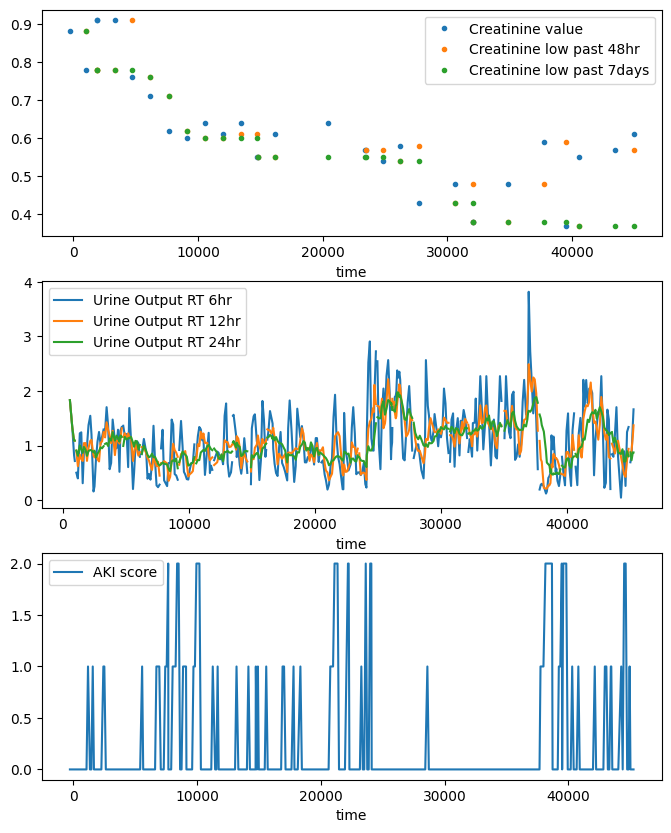

In [33]:
f, axs = plt.subplots(3,1,figsize=(8,10))
pz_tbl = kdigo_stages.query("a_patientid==4016104").sort_values(by='time')

_ = pz_tbl.plot(x='time', y='aki_stage', ax=axs[2], label='AKI score')
_ = pz_tbl.plot(x='time', y='creat', style='.', ax=axs[0], label='Creatinine value')
_ = pz_tbl.plot(x='time', y='creat_48hr', style='.', ax=axs[0], label='Creatinine low past 48hr')
_ = pz_tbl.plot(x='time', y='creat_7days', style='.', ax=axs[0], label='Creatinine low past 7days')
_ = pz_tbl.plot(x='time', y='uo_rt_6hr', ax=axs[1], label='Urine Output RT 6hr')
_ = pz_tbl.plot(x='time', y='uo_rt_12hr', ax=axs[1], label='Urine Output RT 12hr')
_ = pz_tbl.plot(x='time', y='uo_rt_24hr', ax=axs[1], label='Urine Output RT 24hr')
plt.show()